# Diplodatos Kaggle Competition

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import CategoricalNB, GaussianNB, MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from utils import display_markdown

In [2]:
def transform_data(train_data_fname, test_data_fname):
    df_train = pd.read_csv(train_data_fname)
    df_train['is_train_set'] = 1
    df_test = pd.read_csv(test_data_fname)
    df_test['is_train_set'] = 0

    # we  get the TripType for the train set. To do that, we group by VisitNumber and
    # then we get the max (or min or avg)
    y = df_train.groupby(["VisitNumber", "Weekday"], as_index=False).max().TripType

    # we remove the TripType now, and concat training and testing data
    # the concat is done so that we have the same columns for both datasets
    # after one-hot encoding
    df_train = df_train.drop("TripType", axis=1)
    df = pd.concat([df_train, df_test])
    
    # the next three operations are the ones we have just presented in the previous lines
    
    # drop the columns we won't use (it may be good to use them somehow)
    df = df.drop(["Upc", "FinelineNumber"], axis=1)

    # one-hot encoding for the DepartmentDescription
    df = pd.get_dummies(df, columns=["DepartmentDescription"], dummy_na=True)

    # now we add the groupby values
    df = df.groupby(["VisitNumber", "Weekday"], as_index=False).sum()
    
    # finally, we do one-hot encoding for the Weekday
    df = pd.get_dummies(df, columns=["Weekday"], dummy_na=True)

    # get train and test back
    df_train = df[df.is_train_set != 0]
    df_test = df[df.is_train_set == 0]
    
    X = df_train.drop(["is_train_set"], axis=1)
    yy = None
    XX = df_test.drop(["is_train_set"], axis=1)

    return X, y, XX, yy

Load the data...

In [3]:
X, y, XX, yy = transform_data("./data/train.csv", "./data/test.csv")

Create the model and evaluate it

In [4]:
# split training dataset into train and "validation" 
# (we won't be using validation set in this example, because of the cross-validation;
# but it could be useful for you depending on your approach)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

X_train

,VisitNumber,ScanCount,DepartmentDescription_1-HR PHOTO,DepartmentDescription_ACCESSORIES,DepartmentDescription_AUTOMOTIVE,DepartmentDescription_BAKERY,DepartmentDescription_BATH AND SHOWER,DepartmentDescription_BEAUTY,DepartmentDescription_BEDDING,DepartmentDescription_BOOKS AND MAGAZINES,...,DepartmentDescription_WIRELESS,DepartmentDescription_nan,Weekday_Friday,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday,Weekday_nan
81954,163907,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
32578,65166,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
86578,173052,5,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
85079,170137,7,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
9788,19404,32,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52950,106158,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
8809,17442,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
78302,156542,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1229,2404,8,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [5]:
# results dataframe is used to store the computed results
results = pd.DataFrame(columns=('clf', 'best_acc'))

In [6]:
"""
# Original:
model_param = {
    'criterion': ('gini', 'entropy'),
    'min_samples_leaf': (1, 2, 5),
    'min_samples_split': (2, 3, 5, 10, 50, 100)
}
model = DecisionTreeClassifier(random_state=42)
"""

"""
Best models so far (from better to worse):

# No enviado!
MLPClassifier(
    alpha=0.03,
    beta_1=0.8,
    beta_2=0.99999,
    hidden_layer_sizes=(96,),
    max_iter=300,
    n_iter_no_change=30,
    random_state=42
)



MLPClassifier(
    alpha=0.03,
    hidden_layer_sizes=(96,),
    max_iter=300,
    n_iter_no_change=30,
    random_state=42
)
MLPClassifier(
    alpha=0.02,
    hidden_layer_sizes=(64,),
    max_iter=300,
    random_state=42
)
DecisionTreeClassifier(
    random_state=42,
    min_samples_leaf=5,
    min_samples_split=101,
    max_depth=59,
    class_weight={999: 0.49}
)
"""

model_param = {
    'beta_1': (0.8,),
    'beta_2': (0.99999,),
}
model = MLPClassifier(random_state=42,
                      verbose=True,
                      max_iter=300,
                      alpha=0.03,
                      n_iter_no_change=30,
                      hidden_layer_sizes=(96,))

search = GridSearchCV(model,
                      model_param,
                      cv=3,
                      n_jobs=-1,  # Use all processors.
                      scoring='accuracy',
                      verbose=1)  # scoring='balanced_accuracy'

# NOTICE we exclude visit number; it's just an index,
# it messes up the training.
search.fit(X_train.drop(columns=['VisitNumber']), y_train)

best_found_clf = search.best_estimator_

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.3min finished


Iteration 1, loss = 2.28674052
Iteration 2, loss = 1.31093222
Iteration 3, loss = 1.15790133
Iteration 4, loss = 1.09663572
Iteration 5, loss = 1.05953026
Iteration 6, loss = 1.03445582
Iteration 7, loss = 1.01706251
Iteration 8, loss = 1.00225217
Iteration 9, loss = 0.98997892
Iteration 10, loss = 0.97956292
Iteration 11, loss = 0.97005799
Iteration 12, loss = 0.96265076
Iteration 13, loss = 0.95459246
Iteration 14, loss = 0.94900034
Iteration 15, loss = 0.94254913
Iteration 16, loss = 0.93711596
Iteration 17, loss = 0.93326171
Iteration 18, loss = 0.92768156
Iteration 19, loss = 0.92412697
Iteration 20, loss = 0.92019768
Iteration 21, loss = 0.91722915
Iteration 22, loss = 0.91399503
Iteration 23, loss = 0.91063932
Iteration 24, loss = 0.90832256
Iteration 25, loss = 0.90624154
Iteration 26, loss = 0.90331874
Iteration 27, loss = 0.90168567
Iteration 28, loss = 0.89933657
Iteration 29, loss = 0.89743939
Iteration 30, loss = 0.89601150
Iteration 31, loss = 0.89432808
Iteration 32, los

/home/javiergallo/miniconda3/envs/diplodatos/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


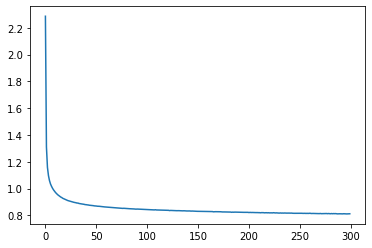

In [8]:
plt.plot(best_found_clf.loss_curve_);

In [9]:
display_markdown('**Best classifier found**:')
print(best_found_clf)
display_markdown('**Accuracy**: {}'.format(search.best_score_))

**Best classifier found**:

MLPClassifier(alpha=0.03, beta_1=0.8, beta_2=0.99999, hidden_layer_sizes=(96,),
              max_iter=300, n_iter_no_change=30, random_state=42, verbose=True)


**Accuracy**: 0.6916879795396419

In [10]:
results = results.append(
    {'clf': best_found_clf, 'best_acc': search.best_score_},
    ignore_index=True
)

In [11]:
results

,clf,best_acc
0,"MLPClassifier(alpha=0.03, beta_1=0.8, beta_2=0...",0.691688


In [12]:
best_clf_idx = results['best_acc'].idxmax()
best_clf = results.loc[best_clf_idx]['clf']
best_acc = results.loc[best_clf_idx]['best_acc']
display_markdown('**The best classifier so far is:**')
print(best_clf)
display_markdown('**Accuracy**: {}'.format(search.best_score_))

**The best classifier so far is:**

MLPClassifier(alpha=0.03, beta_1=0.8, beta_2=0.99999, hidden_layer_sizes=(96,),
              max_iter=300, n_iter_no_change=30, random_state=42, verbose=True)


**Accuracy**: 0.6916879795396419

**And finally**, we predict the unknown label for the testing set

In [13]:
X.shape, XX.shape

((67029, 79), (28645, 79))

In [14]:
# NOTICE we exclude visit number because we didn't use it for training.
yy = best_clf.predict(XX.drop(columns=['VisitNumber']))

The last thing we do is generating a file that should be *submitted* on kaggle

In [15]:
submission = pd.DataFrame(list(zip(XX.VisitNumber, yy)), columns=["VisitNumber", "TripType"])

In [16]:
submission.to_csv("./data/submission.csv", header=True, index=False)